In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import maxentep
# from maxentep import MetaModel, traj_quantile, patch_quantile, contact_infection_func
import numpy as np
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
import tensorflow as tf

C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# uncomment to disable GPU
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# reduce memory usage, in case you're
# on a machine with 1 GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
print (gpus)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        _tf_on_gpu = True
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


# Case 1

10.0

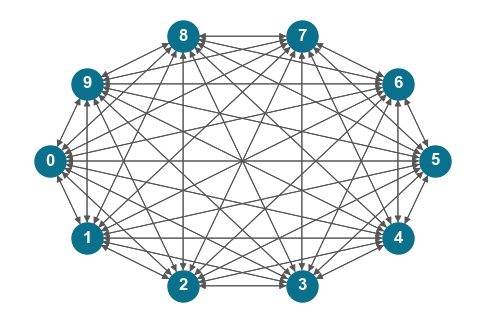

In [3]:
graph_1, edge_list_1, node_list_1 = maxentep.gen_graph(10)
# fig, ax = plt.subplots(dpi=100)

# nx.draw(graph, with_labels=True, pos=nx.shell_layout(graph) , font_weight='bold', ax=ax, **options)
maxentep.draw_graph(graph_1, dpi =100)
dof_1 = maxentep.graph_dof(graph_1.edges(), node_list_1)
dof_1

Reference Model

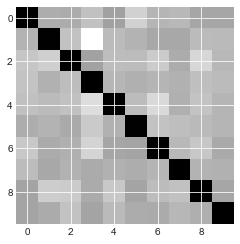

In [4]:
# Make up some population area and mobility network
np.random.seed(0)
M = 10
patches=[f'patch {i}' for i in range(M)]
population = np.round(np.random.normal(loc=500000, scale=300000, size=(M,)))
area = np.maximum(300, np.round(np.random.normal(loc=2000, scale=1000, size=(M,)), 0))
mobility_matrix = np.round(np.abs(np.random.normal(loc=100, scale=50, size=(M,M))))
# setting diagonal values to be dominant
# mobility_matrix[1,:]= 0
# mobility_matrix[:,1]= 0
mobility_matrix_diag = np.round(np.abs(np.random.normal(loc=100000, scale=3000, size=(M))))
np.fill_diagonal(mobility_matrix, mobility_matrix_diag)
mobility_matrix_norm = mobility_matrix / np.sum(mobility_matrix, axis=1, keepdims=True)
plt.imshow(np.log(mobility_matrix))
# np.diagonal(mobility_matrix)
compartments = ['E', 'A', 'I', 'R']
full_compartments = ['S'] + compartments
infections_compartments = [1,2]
C = len(compartments)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Plotting 10 patches in a 3 x 4 grid


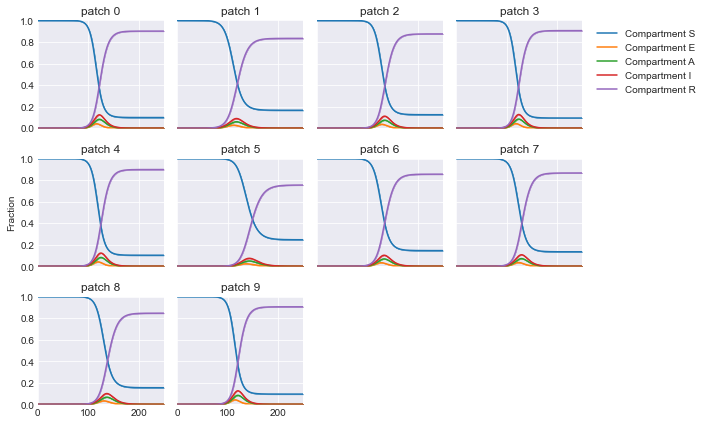

In [5]:
def gen_ref_traj(beta_A = 0.025, beta_I=0.04, alpha =1/3, gamma=1/2, mu=1/7, M=10, timesteps=100, mobility_matrix=mobility_matrix, population=None, area= None):
    tmat = maxentep.TransitionMatrix(compartments, [1,2])
#     eta = 1/2
#     alpha = 1/2
#     mu = 1/5
    tmat.add_transition('E', 'A', 1/alpha, 0) # call this alpha
    tmat.add_transition('E', 'I', 1/gamma, 0) # call this gamma
    tmat.add_transition('A', 'R',1/mu, 0) # mu
    tmat.add_transition('I', 'R', 1/mu, 0) # mu
    infect_fxn = maxentep.contact_infection_func(infections_compartments, area=area)
#     timesteps = 250
    model = maxentep.MetaModel(infect_fxn, timesteps, populations=np.array(population))

    # starting fractions probabilities
    start = np.zeros((M,C)) #anywhere
    # Assume starting from Node 1
    initial_exposed = 1/population[1]
    start[1,0] = initial_exposed
    # start[0,0] = 0.05
#     beta = 0.03
    mobility_matrix_norm = mobility_matrix / np.sum(mobility_matrix, axis=1, keepdims=True)
    ref_traj = model(mobility_matrix_norm, tmat.value, start, np.array([beta_A,beta_I]))[0]
    ref_traj = ref_traj[tf.newaxis, ...]
    return ref_traj
ref_traj_1 = gen_ref_traj(M=10, timesteps=250, population=population,
                          area=area, mobility_matrix=mobility_matrix)
maxentep.patch_quantile(ref_traj_1, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])

Add Restraints

Restraints are set in this time range: [100, 130]
122 0.115495555 0.11485970902444628
115 0.07794935 0.07862578585737402
108 0.03758618 0.03816276944720538
101 0.014988111 0.014779812576480911
122 0.31115723 0.31115736617446216
115 0.15111935 0.15262518974980924
108 0.061619554 0.06172407463833399
101 0.022865044 0.022629000802483326
122 0.12317771 0.12389193101566166
115 0.08916437 0.09144870216273984
108 0.044133984 0.045698086132184526
101 0.017458897 0.018070000793863436
101 0.02596897 0.02531179370168331
122 0.35336334 0.35268235605328646
108 0.07138787 0.07174264176429908
115 0.17553817 0.1741040129637092
101 0.004769402 0.004024647268411622
122 0.06262032 0.06179388088740071
115 0.03021369 0.030115236907122686
108 0.012455157 0.011791678717934672
108 0.019925488 0.018778019506649375
101 0.0074247397 0.006986919610362826
122 0.12316705 0.12266902041433608
115 0.05154792 0.053477450522530744
115 0.09844407 0.0981869392036958
122 0.12172008 0.12352990074600849
101 0.022719767 0.023

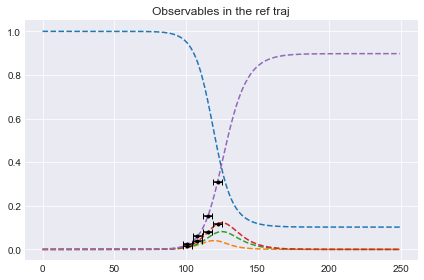

In [6]:
npoints = 4
number_of_restrained_patches = 5
restrained_compartments = [3,4] #(infected patch and recovered)
number_of_restrained_compartments = len(restrained_compartments) 
restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
restrained_compartments_names = " ".join(restrained_compartments_names)
def gen_restraints(ref_traj):
    prior = maxentep.EmptyPrior()

    restrained_patches = np.random.choice(M, number_of_restrained_patches, replace=False)
    # Visualizing restraints
    restrained_patch = restrained_patches[0]
    restraints, plot_fxns_list = maxentep.compartment_restrainer(restrained_patches, restrained_compartments,
                                                                 ref_traj, prior, npoints = npoints, noise=0.001, start_time=100, end_time=130)
    plt.plot(ref_traj[0,:,restrained_patch,:], linestyle='--')
    for i,pf in enumerate(plot_fxns_list[0]):
        pf(plt.gca(), 0)
    plt.title('Observables in the ref traj')
    plt.tight_layout()
    return restraints, plot_fxns_list, restrained_patches
restraints_1, plot_fxns_list_1, restrained_patches_1 = gen_restraints(ref_traj_1)

# Sample

In [7]:
def gen_samples(mobility_matrix, timesteps =250, area = area, populations = population):
    tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
    tmat.add_transition('E', 'A', 2, 1) # call this alpha
    tmat.add_transition('E', 'I', 2, 1) # call this gamma
    tmat.add_transition('A', 'R',5, 2) # mu
    tmat.add_transition('I', 'R', 5, 2)
    hyper_pram = maxentep.ParameterHypers()
    hyper_pram.beta_low = [0.005]*2
    hyper_pram.beta_high = [0.08]*2
    hyper_pram.beta_var = [0.1]*2
    hyper_pram.start_high = 2e-5
    hyper_pram.start_var = 0.5
    hyper_pram.R_var = 100
    hyper_pram.beta_start = 0.005
    hyper_pram.start_mean = 8e-6
    hyper_pram.start_scale = 4e-6
    start_logits = np.zeros((M))
    param_model = maxentep.MetaParameterJoint(start_logits, mobility_matrix , tmat, name='unbiased_model',
                                              hypers = hyper_pram, n_infectious_compartments=2)
    import tqdm
    N = 512
    batches = 8
    total_batches = N * batches
    outs = []
    infect = maxentep.contact_infection_func(infections_compartments, area = area)
    model = maxentep.MetaModel(infect, timesteps, populations = population)
    prior_prams = []
    for b in tqdm.tqdm(range(batches)):
        ps = param_model.sample(N)
        prior_prams.append(ps)
        outs.append(model(*ps))
    trajs = np.concatenate(outs, axis=0)
    param_batch = prior_prams[0]
    mask = tf.greater(param_batch[2], 0)
    start_exposed_dist = tf.boolean_mask(param_batch[2], mask).numpy()
    # prior_param_dist = maxentep.get_dist(prior_prams)
    # maxentep.plot_dist(*prior_param_dist)
    return trajs
trajs_1 = gen_samples(mobility_matrix, timesteps =250, area = area, populations = population)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:18<00:00,  2.26s/it]


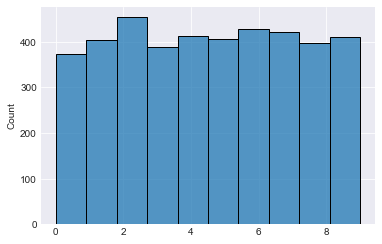

In [8]:
prior_exposed_patch_1 = maxentep.exposed_finder(trajs_1)
# print(np.where(prior_exposed_patch==0))
sns.histplot(x=prior_exposed_patch_1, label='Prior',
            color='C0',bins=M)

In [9]:
def compare_to_ref(ref_traj, trajs, weights, *args, method = None, figsize=(18, 18), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments] and compares to a ref_traj
    '''
#     weights = weights_dict[method]
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.06)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.002)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
#             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[0,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                maxentep.traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
            if j >= NP % ncol:
                ax[nrow-1, j].set_visible(False)
    plt.tight_layout()

Plotting 10 patches in a 3 x 4 grid


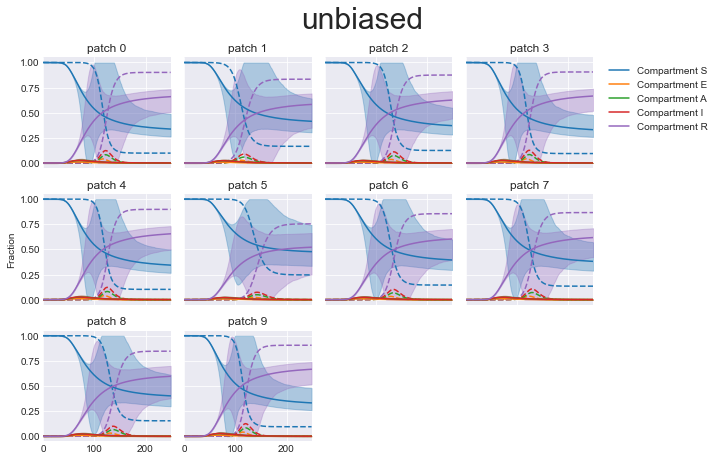

In [10]:
compare_to_ref(ref_traj_1,trajs_1, weights=None, method='unbiased', patch_names = patches,
               figsize=(10, 6), alpha=0.3, names=full_compartments)

# Applying MaxEnt

Epoch 1/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0248 - weight-entropy: 6.5951
Epoch 2/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0193 - weight-entropy: 6.2139
Epoch 3/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0202 - weight-entropy: 6.1716
Epoch 4/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0200 - weight-entropy: 6.1733
Epoch 5/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0190 - weight-entropy: 6.1914
Epoch 6/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0172 - weight-entropy: 6.2171
Epoch 7/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0139 - weight-entropy: 6.2254
Epoch 8/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0096 - weight-entropy: 6.1341
Epoch 9/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0083 - weight-entropy: 5.8535
Epoch 10/500
4/4 [==============================] - 0s 2ms/step - loss: 0

4/4 [==============================] - 0s 1ms/step - loss: 0.0046 - weight-entropy: 4.7762
Epoch 80/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0045 - weight-entropy: 4.6730
Epoch 81/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0049 - weight-entropy: 4.6868
Epoch 82/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0040 - weight-entropy: 4.5074
Epoch 83/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0050 - weight-entropy: 4.7969
Epoch 84/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0043 - weight-entropy: 4.7478
Epoch 85/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0043 - weight-entropy: 4.5806
Epoch 86/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0046 - weight-entropy: 4.6014
Epoch 87/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0053 - weight-entropy: 4.7315
Epoch 88/500
4/4 [==============================] - 0s 2ms/step - loss: 0.004

4/4 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 3.7099
Epoch 158/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0031 - weight-entropy: 3.8840
Epoch 159/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0033 - weight-entropy: 4.1768
Epoch 160/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0035 - weight-entropy: 4.2882
Epoch 161/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 4.0377
Epoch 162/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0036 - weight-entropy: 4.1037
Epoch 163/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0042 - weight-entropy: 4.2338
Epoch 164/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0035 - weight-entropy: 3.9539
Epoch 165/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0035 - weight-entropy: 3.9217
Epoch 166/500
4/4 [==============================] - 0s 2ms/step - lo

4/4 [==============================] - 0s 1ms/step - loss: 0.0037 - weight-entropy: 4.0616
Epoch 236/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0037 - weight-entropy: 4.2261
Epoch 237/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 3.8724
Epoch 238/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 3.8916
Epoch 239/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0033 - weight-entropy: 4.1391
Epoch 240/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0042 - weight-entropy: 4.3435
Epoch 241/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0030 - weight-entropy: 4.0262
Epoch 242/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0032 - weight-entropy: 3.6770
Epoch 243/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 3.5837
Epoch 244/500
4/4 [==============================] - 0s 1ms/step - lo

4/4 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 3.5997
Epoch 314/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 3.6303
Epoch 315/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0032 - weight-entropy: 3.7293
Epoch 316/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0034 - weight-entropy: 3.8606
Epoch 317/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 3.6914
Epoch 318/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 3.4667
Epoch 319/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0038 - weight-entropy: 3.7799
Epoch 320/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0038 - weight-entropy: 3.7949
Epoch 321/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0028 - weight-entropy: 3.4979
Epoch 322/500
4/4 [==============================] - 0s 1ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 3.6044
Epoch 392/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 3.5139
Epoch 393/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 3.4095
Epoch 394/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0017 - weight-entropy: 3.2586
Epoch 395/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 3.2392
Epoch 396/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 3.2903
Epoch 397/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 3.3691
Epoch 398/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0031 - weight-entropy: 3.5879
Epoch 399/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 3.3535
Epoch 400/500
4/4 [==============================] - 0s 1ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0021 - weight-entropy: 3.0043
Epoch 469/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 2.8976
Epoch 470/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 3.1752
Epoch 471/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 3.3134
Epoch 472/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 3.0285
Epoch 473/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0037 - weight-entropy: 3.3168
Epoch 474/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 3.2310
Epoch 475/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 2.9408
Epoch 476/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 2.8592
Epoch 477/500
4/4 [==============================] - 0s 2ms/step - lo

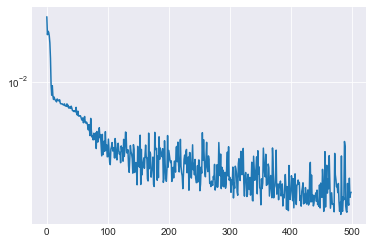

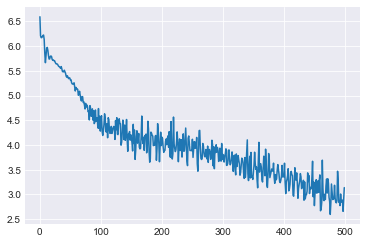

In [11]:
def maxent_fit(trajs,restraints):
    me_model = maxentep.MaxentModel(restraints)
    me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-1), 'mean_squared_error')
    me_history = me_model.fit(trajs, batch_size=1024,epochs=500)
    plt.plot(me_history.history['loss'])
    plt.yscale('log')
    plt.show()
    plt.plot(me_history.history['weight-entropy'])
    return me_model
me_model_1 = maxent_fit(trajs_1, restraints_1)

In [12]:
def compare_patches(ref_traj, trajs,weights_dict, method, restrained_patches,plot_fxns_list,
                    *args, figsize=(10, 6), patch_names=None, ** kw_args):
    '''does traj_quantile for trajectories of shape [ntrajs, time, patches, compartments]
    '''
    weights = weights_dict[method]
#     p = 1
    NP = trajs.shape[2]
    nrow = int(np.floor(np.sqrt(NP)))
    ncol = int(np.ceil(NP / nrow))
    print(f'Plotting {NP} patches in a {nrow} x {ncol} grid')
    fig, ax = plt.subplots(nrow, ncol, sharex=True,
                           sharey=True, figsize=figsize)
    if method =='unbiased':
        fig.suptitle('{}'.format(method), fontsize=30,y=1.03)
    else:
        fig.suptitle('{} (Patches restrained: {}, Points restrained in each patch: {}, Compartments restrained: {})'
                     .format(method,len(restrained_patches),npoints*number_of_restrained_compartments,restrained_compartments_names)
                     , fontsize=26,y=1.03)
    for i in range(nrow):
        for j in range(ncol):
            if i * ncol + j == NP:
                break
#             traj_quantile(trajs[:,:,i * ncol + j,:], weights=weights, names=full_compartments, ax=axs[0,i])
            ax[i,j].plot(ref_traj[0,:,i * ncol + j,:], linestyle='--')
            if method == 'unbiased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :], *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'biased':
                maxentep.traj_quantile(trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'hyper-biased':
                maxentep.traj_quantile(hme_model.trajs[:, :, i * ncol + j, :],weights= weights, *args, ax=ax[i, j],
                              add_legend=i == 0 and j == ncol - 1, **kw_args)
            elif method == 'regression':
                ax[i,j].plot(rtraj[p,:,i * ncol + j,:])
#             ax[i, j].set_ylim(0, 1)
            if i * ncol + j in restrained_patches and method != 'unbiased':
                for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i * ncol + j)]):
                    pf(ax[i,j],0, color='C3')
                ax[i,j].spines['bottom'].set_color('y')
                ax[i,j].spines['top'].set_color('y') 
                ax[i,j].spines['right'].set_color('y')
                ax[i,j].spines['left'].set_color('y')
                ax[i,j].spines['left'].set_linewidth(2)
                ax[i,j].spines['top'].set_linewidth(2)
                ax[i,j].spines['right'].set_linewidth(2)
                ax[i,j].spines['bottom'].set_linewidth(2)
#             plt.tight_layout()
            if patch_names is None:
                ax[i, j].text(trajs.shape[1] // 2, 0.8,
                              f'Patch {i * ncol + j}')
            else:
                patch_names = patch_names
                ax[i, j].set_title(patch_names[i * ncol + j])

            if j == 0 and i == nrow // 2:
                ax[i, j].set_ylabel('Fraction')
            if i == nrow - 1 and j == ncol // 2:
                ax[i, j].set_xlabel('Time')
            if j >= NP % ncol:
                ax[nrow-1, j].set_visible(False)
    plt.tight_layout()


Plotting 10 patches in a 3 x 4 grid


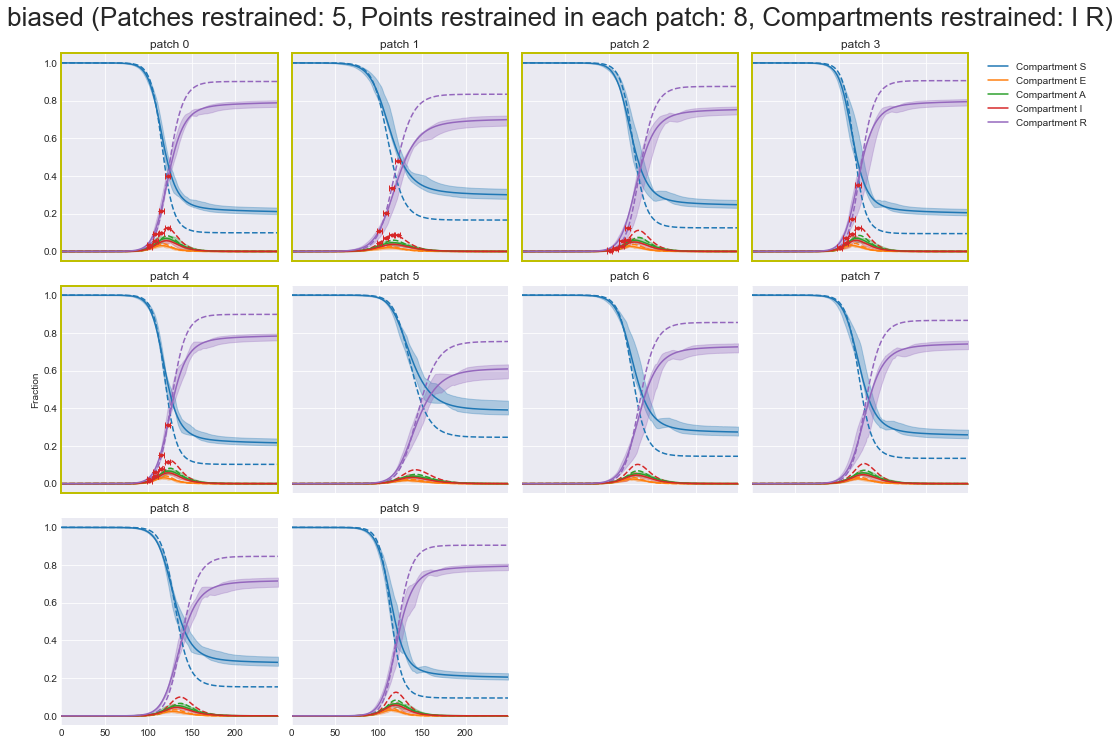

In [13]:
weights_dict_1 = {'unbiased':None, 'biased':me_model_1.traj_weights}
compare_patches(ref_traj_1, trajs_1, weights_dict_1,'biased', restrained_patches_1,plot_fxns_list_1,
                patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)

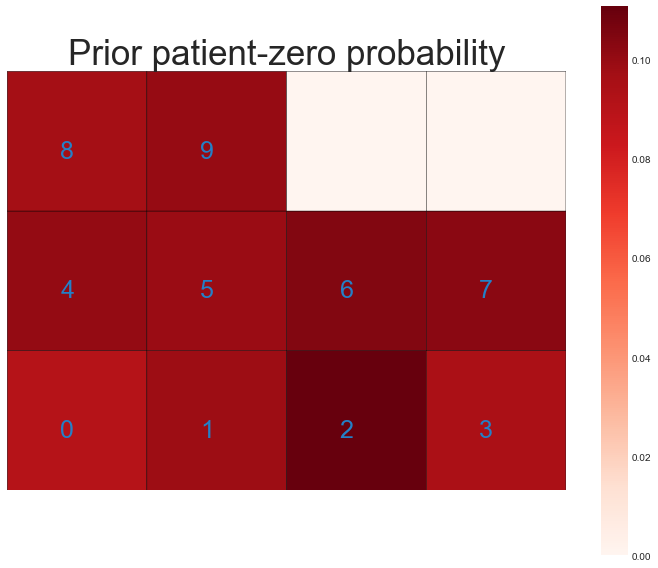

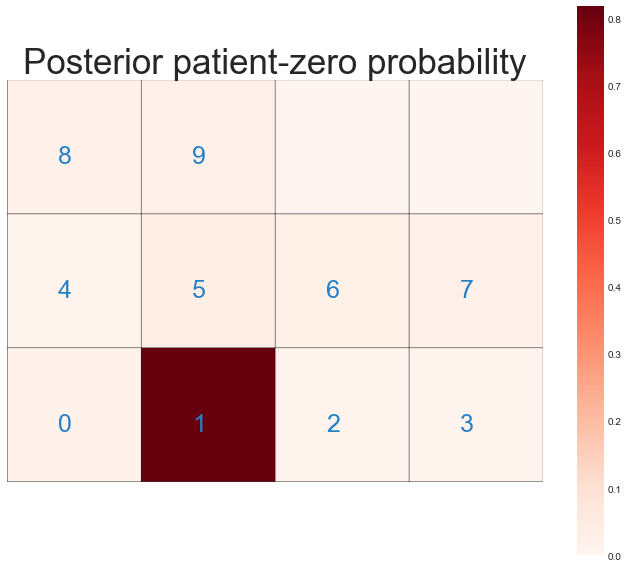

In [14]:
prior_exposed_patch_1 = maxentep.exposed_finder(trajs_1)
me_w_1 = me_model_1.traj_weights
maxentep.p0_map(prior_exposed_patch_1, M, weights = None, title = 'Prior patient-zero probability', fontsize=25, figsize=(10,8))
maxentep.p0_map(prior_exposed_patch_1, M, weights = me_w_1, title = 'Posterior patient-zero probability', fontsize=25,figsize=(10,8))

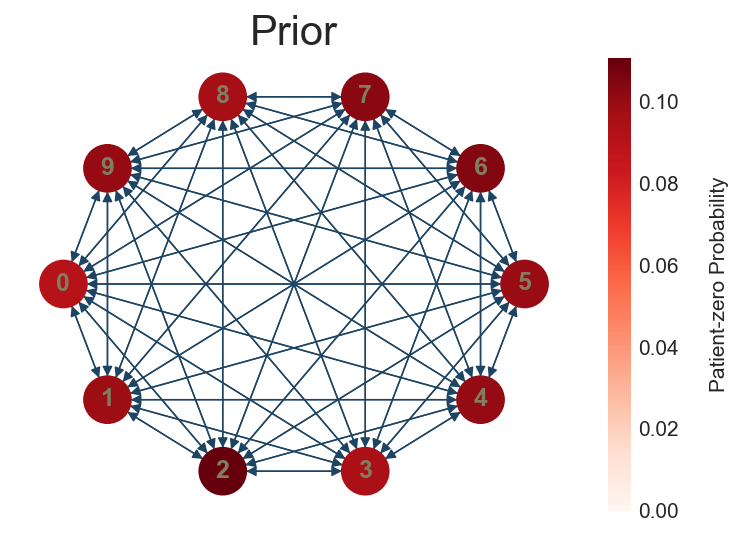

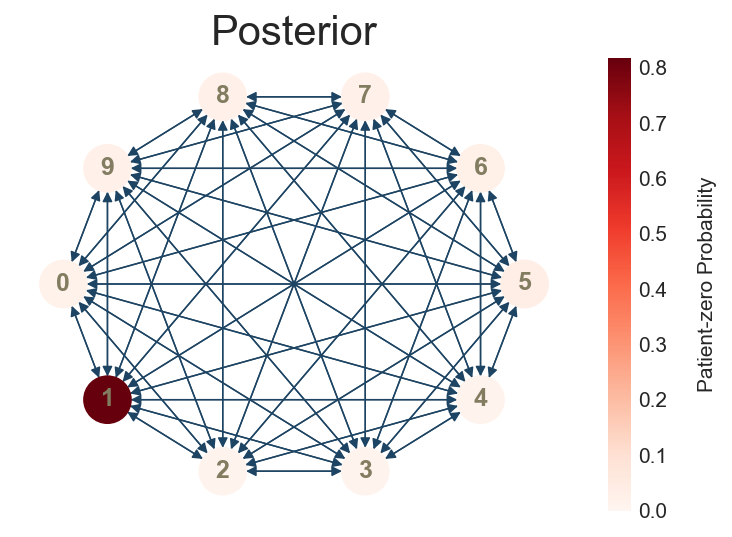

In [15]:
exposed_prob_1 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_1, M)
weighted_exposed_prob_1 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_1, M, weights=me_w_1)
maxentep.draw_graph(graph_1, weights=exposed_prob_1, title='Prior', heatmap=True)
fig, ax = plt.subplots()
maxentep.draw_graph(graph_1, weights=weighted_exposed_prob_1, title='Posterior', heatmap=True)

In [16]:
true_p0_node = 1
traj_loss_1 = maxentep.traj_loss(ref_traj_1, trajs_1, me_w_1)
p0_loss_1 = maxentep.p0_loss(trajs_1,me_w_1, true_p0_node)
# posterior_exposed_prob = maxentep.weighted_exposed_prob_finder(prior_exposed_patch, M, weights = me_w)
print(f'P0 cross-entropy : {p0_loss_1:.3f}, Traj KL : {traj_loss_1:.3f}')
print('Top 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob_1, patches), reverse=True)[:5])


P0 cross-entropy : 0.200, Traj KL : 0.029
Top 5 posterior probabilities for P0: 
 [(0.8185468961686253, 'patch 1'), (0.036477635664740334, 'patch 5'), (0.0273149900725798, 'patch 6'), (0.02359018745738871, 'patch 8'), (0.02254489273612593, 'patch 7')]


 # Case 2

6.9

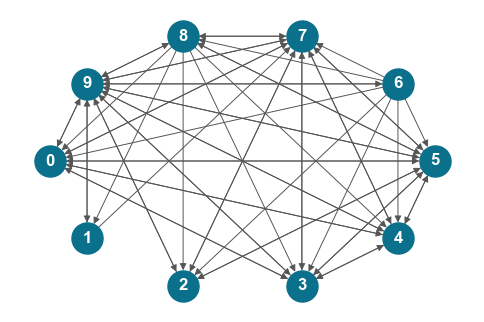

In [17]:
graph_2, edge_list_2, node_list_2 = maxentep.gen_graph(10)
# fig, ax = plt.subplots(dpi=100)
graph_2.remove_edges_from([(1, i) for i in range(0,7) if i!=1])
graph_2.remove_edges_from([(i, 1) for i in range(0,8)  if i!=1])
graph_2.remove_edges_from([(2, i) for i in range(0,5) if i!=2])
graph_2.remove_edges_from([(i,2) for i in range(0,5)  if i!=2])
graph_2.remove_edges_from([(i,8) for i in range(0,5)  if i!=8])
graph_2.remove_edges_from([(i,6) for i in range(0,9)  if i!=6])
maxentep.draw_graph(graph_2, dpi=100)
# nx.draw(graph_2, with_labels=True, pos=nx.shell_layout(graph_2) , font_weight='bold', ax=ax, **options)
dof_2 = maxentep.graph_dof(graph_2.edges(), node_list_2)
dof_2

In [18]:
def sparse_graph_mobility(sparse_graph, fully_connected_mobility_matrix):
    R'''
    Generates a sprase mobility matrix based on a sparse graph and a fully connected mobility matrix inputs
    '''
    sparse_mobility_matrix = np.zeros_like(fully_connected_mobility_matrix)
    for i, edge in enumerate(sparse_graph.edges()):
        sparse_mobility_matrix[edge[0], edge[1]] = fully_connected_mobility_matrix[edge[0], edge[1]]
    return sparse_mobility_matrix


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Plotting 10 patches in a 3 x 4 grid


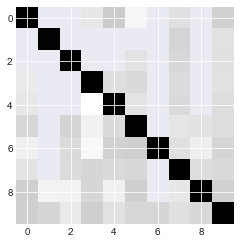

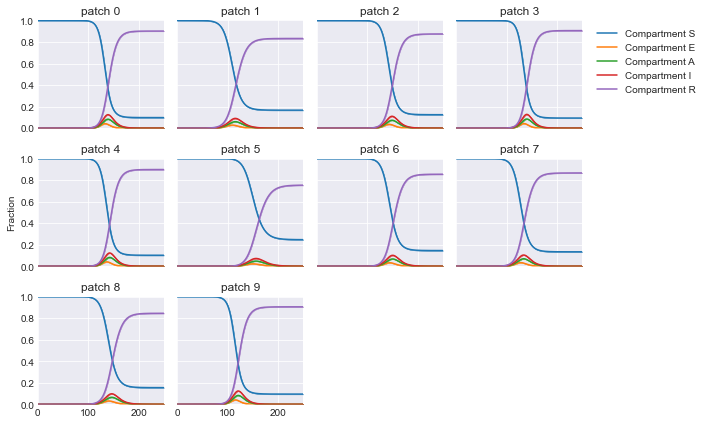

In [19]:
sparse_mobility_matrix_2 = sparse_graph_mobility(graph_2, mobility_matrix)
plt.imshow(np.log(sparse_mobility_matrix_2))
sparse_ref_traj_2 = gen_ref_traj(M=10, timesteps=250, population=population,
                               area=area, mobility_matrix=sparse_mobility_matrix_2)
maxentep.patch_quantile(sparse_ref_traj_2, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])

Restraints are set in this time range: [100, 130]
115 0.10540361 0.10429922623441265
108 0.061291493 0.06134365855469814
122 0.120776124 0.12003656130218122
101 0.026829911 0.02837292599131414
101 0.042077936 0.04157304002379087
122 0.43633083 0.4358860672877964
115 0.24324894 0.24362607571002845
108 0.10875301 0.10811590413073087
122 0.0120278215 0.012420129559235491
108 0.0016564392 0.0018980739618951357
115 0.004590985 0.004694920811829031
101 0.00057700824 0.0
108 0.0024070926 0.0017311926696753988
122 0.018957015 0.018034468801464747
115 0.006881315 0.006432728449767701
101 0.0008227728 0.0010047518948559494
101 0.053787287 0.05488694692055409
108 0.07896448 0.0796197429983198
122 0.079048894 0.07968902587185794
115 0.08983905 0.0882220926393325
115 0.38220358 0.3835865212834353
101 0.13148151 0.13186842621934666
108 0.23989142 0.2385589715956383
122 0.526785 0.5272888335442849
108 0.0031417892 0.003663776961054763
115 0.009099903 0.010297162450006782
122 0.024537044 0.02415455743

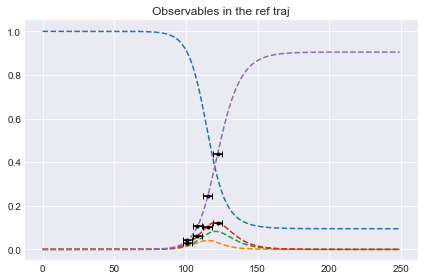

In [22]:
restraints_2, plot_fxns_list_2, restrained_patches_2 = gen_restraints(sparse_ref_traj_2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:16<00:00,  2.04s/it]


Plotting 10 patches in a 3 x 4 grid


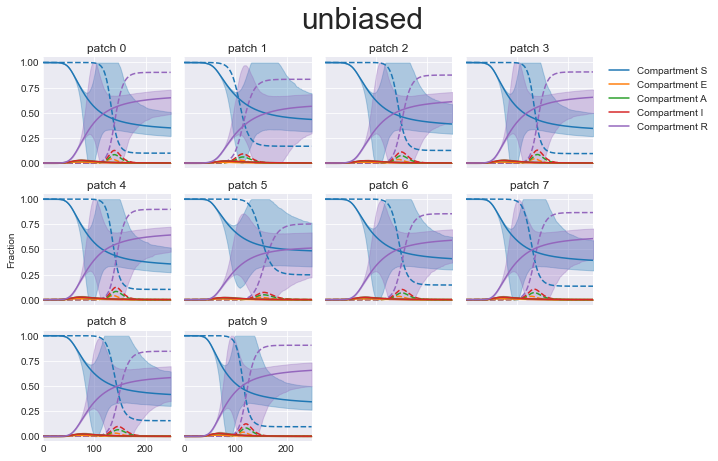

In [23]:
sparse_trajs_2 = gen_samples(sparse_mobility_matrix_2, timesteps =250, area = area, populations = population)
compare_to_ref(sparse_ref_traj_2, sparse_trajs_2, weights=None, method='unbiased',
               patch_names = patches, figsize=(10, 6), alpha=0.3, names=full_compartments)

Epoch 1/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0269 - weight-entropy: 6.6138
Epoch 2/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0171 - weight-entropy: 6.2446
Epoch 3/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0179 - weight-entropy: 6.1853
Epoch 4/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0181 - weight-entropy: 6.1687
Epoch 5/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0181 - weight-entropy: 6.1658
Epoch 6/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0180 - weight-entropy: 6.1706
Epoch 7/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0178 - weight-entropy: 6.1800
Epoch 8/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0175 - weight-entropy: 6.1933
Epoch 9/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0171 - weight-entropy: 6.2098
Epoch 10/500
4/4 [==============================] - 0s 1ms/step - loss: 0

4/4 [==============================] - 0s 2ms/step - loss: 0.0034 - weight-entropy: 4.2398
Epoch 80/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 4.3425
Epoch 81/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0042 - weight-entropy: 4.5978
Epoch 82/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0044 - weight-entropy: 4.1883
Epoch 83/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0033 - weight-entropy: 4.2139
Epoch 84/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0027 - weight-entropy: 4.2580
Epoch 85/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0029 - weight-entropy: 4.4535
Epoch 86/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 4.2711
Epoch 87/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0048 - weight-entropy: 4.4788
Epoch 88/500
4/4 [==============================] - 0s 1ms/step - loss: 0.002

4/4 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 3.6203
Epoch 158/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 3.6120
Epoch 159/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0023 - weight-entropy: 3.6321
Epoch 160/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 3.5075
Epoch 161/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 3.5873
Epoch 162/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0017 - weight-entropy: 3.7594
Epoch 163/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0038 - weight-entropy: 3.7428
Epoch 164/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0014 - weight-entropy: 3.2184
Epoch 165/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 3.3262
Epoch 166/500
4/4 [==============================] - 0s 1ms/step - lo

4/4 [==============================] - 0s 1ms/step - loss: 0.0010 - weight-entropy: 2.6659
Epoch 235/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0038 - weight-entropy: 3.4674
Epoch 236/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0014 - weight-entropy: 3.0380
Epoch 237/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 2.7738
Epoch 238/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 2.7747
Epoch 239/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0014 - weight-entropy: 2.9478
Epoch 240/500
4/4 [==============================] - 0s 1ms/step - loss: 9.4053e-04 - weight-entropy: 2.6310
Epoch 241/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 2.8714
Epoch 242/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0014 - weight-entropy: 2.8228
Epoch 243/500
4/4 [==============================] - 0s 1ms/step 

4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 2.0439
Epoch 312/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 2.7624
Epoch 313/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 2.2784
Epoch 314/500
4/4 [==============================] - 0s 1ms/step - loss: 8.5080e-04 - weight-entropy: 2.2596
Epoch 315/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 2.4392
Epoch 316/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 3.3210
Epoch 317/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 2.2945
Epoch 318/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 2.4952
Epoch 319/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 1.9381
Epoch 320/500
4/4 [==============================] - 0s 2ms/step 

4/4 [==============================] - 0s 1ms/step - loss: 9.7878e-04 - weight-entropy: 2.0203
Epoch 389/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 2.2041
Epoch 390/500
4/4 [==============================] - 0s 1ms/step - loss: 9.4693e-04 - weight-entropy: 1.7149
Epoch 391/500
4/4 [==============================] - 0s 1ms/step - loss: 8.9162e-04 - weight-entropy: 2.0359
Epoch 392/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 2.2684
Epoch 393/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0014 - weight-entropy: 2.4685
Epoch 394/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 2.4361
Epoch 395/500
4/4 [==============================] - 0s 1ms/step - loss: 9.4258e-04 - weight-entropy: 2.3967
Epoch 396/500
4/4 [==============================] - 0s 2ms/step - loss: 7.7769e-04 - weight-entropy: 1.8538
Epoch 397/500
4/4 [==============================

4/4 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 1.8574
Epoch 465/500
4/4 [==============================] - 0s 1ms/step - loss: 8.5392e-04 - weight-entropy: 1.6132
Epoch 466/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 1.9904
Epoch 467/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 2.3525
Epoch 468/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 2.6283
Epoch 469/500
4/4 [==============================] - 0s 2ms/step - loss: 8.8053e-04 - weight-entropy: 1.7362
Epoch 470/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 2.2904
Epoch 471/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 1.7536
Epoch 472/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 1.7482
Epoch 473/500
4/4 [==============================] - 0s 1ms/s

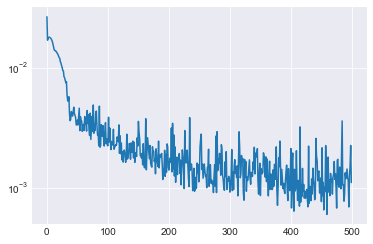

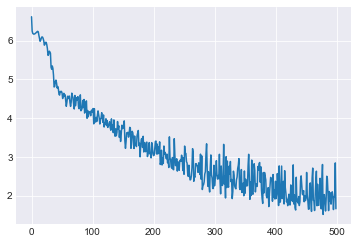

In [24]:
sparse_me_model_2 = maxent_fit(sparse_trajs_2, restraints_2)

Plotting 10 patches in a 3 x 4 grid


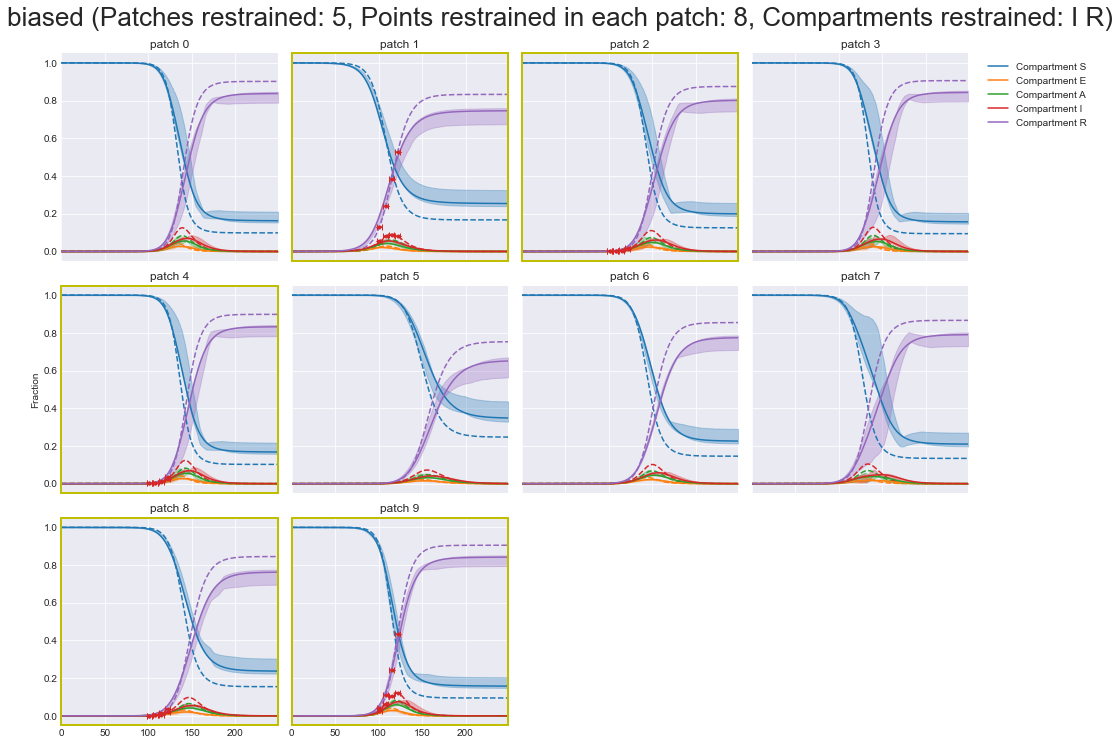

In [25]:
weights_dict_2 = {'unbiased':None, 'biased':sparse_me_model_2.traj_weights}
compare_patches(sparse_ref_traj_2, sparse_trajs_2, weights_dict_2,'biased', restrained_patches_2, plot_fxns_list_2,
                patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)

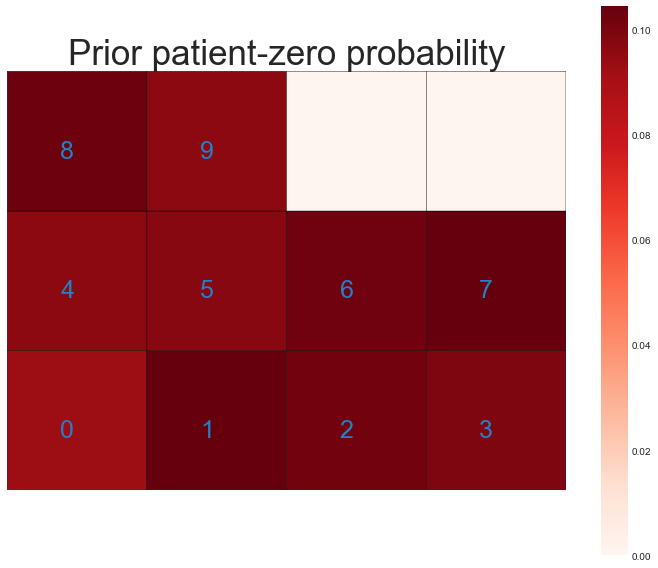

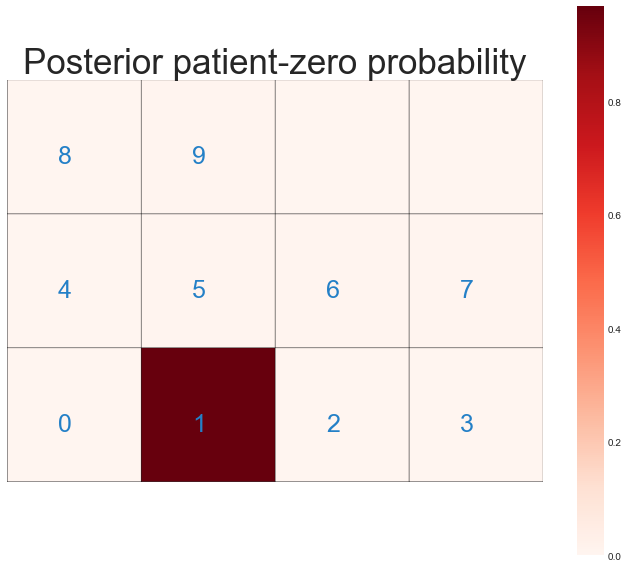

In [26]:
me_w_2 = sparse_me_model_2.traj_weights
prior_exposed_patch_2 = maxentep.exposed_finder(sparse_trajs_2)
maxentep.p0_map(prior_exposed_patch_2, M, weights = None, title = 'Prior patient-zero probability', fontsize=25, figsize=(10,8))
maxentep.p0_map(prior_exposed_patch_2, M, weights = me_w_2, 
                title = 'Posterior patient-zero probability', fontsize=25,figsize=(10,8))

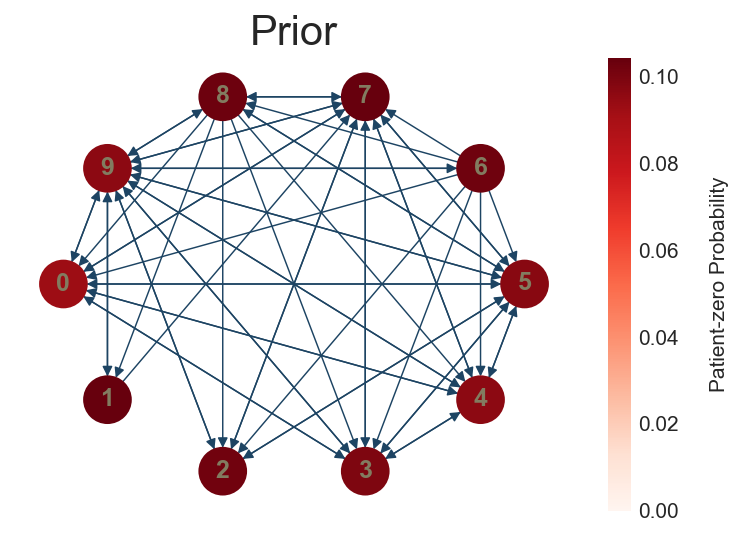

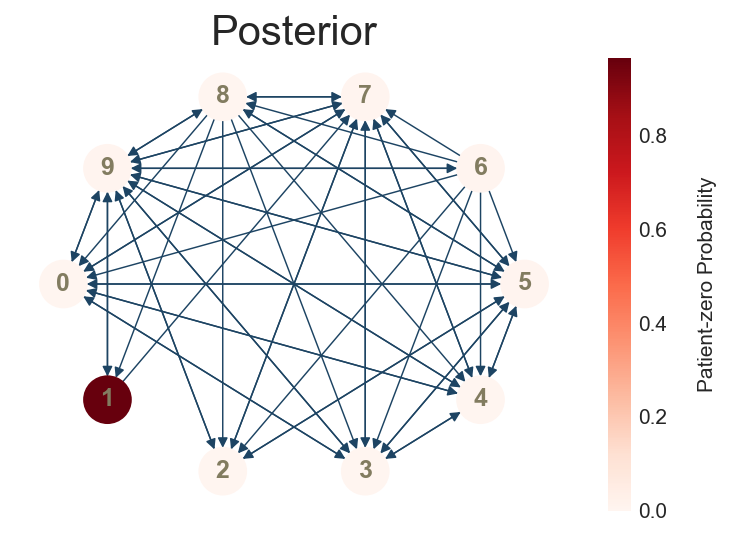

In [27]:
exposed_prob_2 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_2, M)
weighted_exposed_prob_2 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_2, M, weights=me_w_2)
maxentep.draw_graph(graph_2, weights=exposed_prob_2, title='Prior', heatmap=True)
fig, ax = plt.subplots()
maxentep.draw_graph(graph_2, weights=weighted_exposed_prob_2, title='Posterior', heatmap=True)

In [29]:
traj_loss_2 = maxentep.traj_loss(sparse_ref_traj_2, sparse_trajs_2, me_w_2)
p0_loss_2 = maxentep.p0_loss(sparse_trajs_2,me_w_2,true_p0_node)
print(f'P0 cross-entropy : {p0_loss_2:.3f}, Traj KL : {traj_loss_2:.3f}')
print('Top 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob_2, patches), reverse=True)[:5])

P0 cross-entropy : 0.033, Traj KL : 0.017
Top 5 posterior probabilities for P0: 
 [(0.9670553348880312, 'patch 1'), (0.00472279825421006, 'patch 5'), (0.004469159019661434, 'patch 6'), (0.003934544830560899, 'patch 7'), (0.003910946974456673, 'patch 9')]


# Case 3

4.5

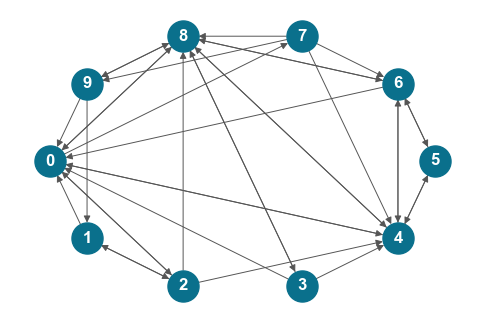

In [30]:
graph_3, edge_list_3, node_list_3 = maxentep.gen_graph(10)
graph_3.remove_edges_from([(1, i) for i in range(3,9)])
graph_3.remove_edges_from([(i, 1) for i in range(0,9) if i != 2 and i != 1])
graph_3.remove_edges_from([(i, 2) for i in range(3,9) ])
graph_3.remove_edges_from([(i, 6) for i in range(0,4)])
graph_3.remove_edges_from([(i, 7) for i in range(1,10) if i != 7])
graph_3.remove_edges_from([(7, i) for i in range(0,5) if i!=4])
graph_3.remove_edges_from([(5, i) for i in range(0,9) if i!=6 and i!=4 and i!=5])
graph_3.remove_edges_from([(i, 5) for i in range(0,9)  if i!=6 and i!=4 and i!=5])
graph_3.remove_edges_from([(i, 3) for i in range(0,7) if i!=3])
graph_3.remove_edges_from([(9,i) for i in range(2,8)])
graph_3.remove_edges_from([(i,9) for i in range(0,7)])
# graph.remove_edges_from([(i,4) for i in range(0,7)])
maxentep.draw_graph(graph_3,dpi=100)
dof_3 = maxentep.graph_dof(graph_3.edges(), node_list_3)
dof_3


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Plotting 10 patches in a 3 x 4 grid


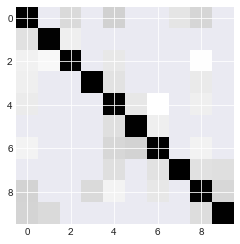

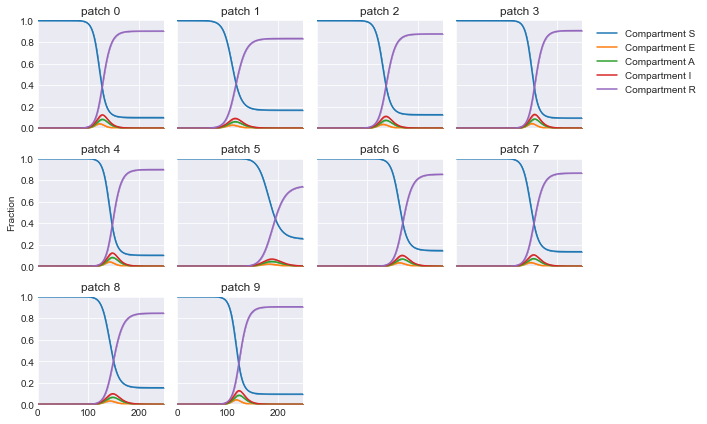

In [31]:
sparse_mobility_matrix_3 = sparse_graph_mobility(graph_3, mobility_matrix)
plt.imshow(np.log(sparse_mobility_matrix_3))
sparse_ref_traj_3 = gen_ref_traj(M=10, timesteps=250, population=population,
                               area=area, mobility_matrix=sparse_mobility_matrix_3)
maxentep.patch_quantile(sparse_ref_traj_3, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])

Restraints are set in this time range: [100, 130]
108 0.05076637 0.050774337464197766
115 0.09697069 0.0980592651960632
101 0.020690132 0.020769110235137285
122 0.12428466 0.12509074463816558
108 0.08426815 0.08315914808059538
115 0.20113523 0.20033229937268596
101 0.031141803 0.032015936163021
122 0.38814515 0.38828020538239877
101 0.00033131754 0.0012071503018455001
108 0.0009822365 0.0008671289978832963
122 0.0075553097 0.008012725289305479
115 0.0028076486 0.0018430366059031648
115 0.004078666 0.004793023398877905
101 0.00045773902 0.00021667154587457708
108 0.0013826654 0.001206706542834388
122 0.011567414 0.012578875530104516
101 0.009924008 0.009655752833029349
108 0.026211465 0.02491360965705059
115 0.060189243 0.060785296297652294
122 0.104445554 0.10358017888424954
115 0.106328905 0.10404126470279607
108 0.04104476 0.040493286370231606
101 0.014788656 0.015996276229217826
122 0.23893516 0.23778335959058883
108 0.07932959 0.07849570776811036
122 0.07875639 0.07711288865010475


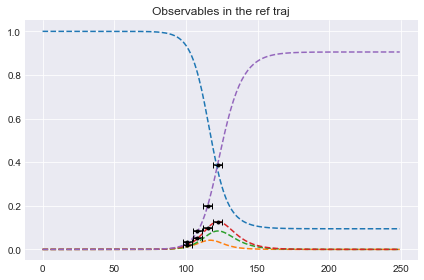

In [35]:
restraints_3, plot_fxns_list_3, restrained_patches_3 = gen_restraints(sparse_ref_traj_3)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:16<00:00,  2.08s/it]


Plotting 10 patches in a 3 x 4 grid


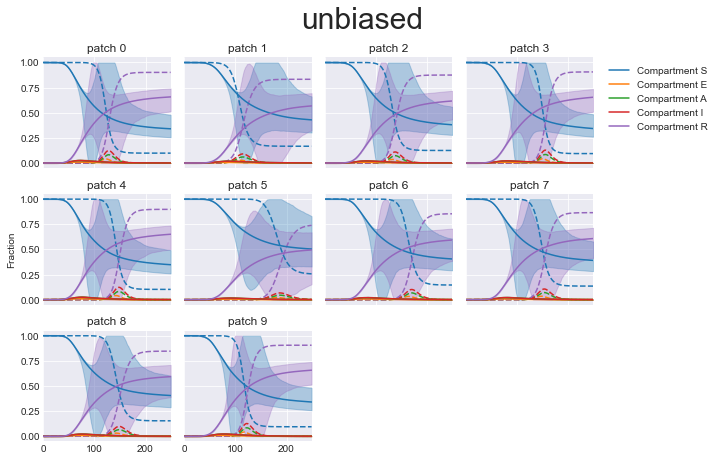

In [36]:
sparse_trajs_3 = gen_samples(sparse_mobility_matrix_3, timesteps =250, area = area, populations = population)
compare_to_ref(sparse_ref_traj_3, sparse_trajs_3, weights=None, method='unbiased', patch_names = patches,
               figsize=(10, 6), alpha=0.3, names=full_compartments)

Epoch 1/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0228 - weight-entropy: 6.6422
Epoch 2/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0174 - weight-entropy: 6.3100
Epoch 3/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0182 - weight-entropy: 6.2562
Epoch 4/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0184 - weight-entropy: 6.2439
Epoch 5/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0183 - weight-entropy: 6.2461
Epoch 6/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0180 - weight-entropy: 6.2571
Epoch 7/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0176 - weight-entropy: 6.2730
Epoch 8/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0170 - weight-entropy: 6.2924
Epoch 9/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0161 - weight-entropy: 6.3088
Epoch 10/500
4/4 [==============================] - 0s 2ms/step - loss: 0

4/4 [==============================] - 0s 1ms/step - loss: 0.0037 - weight-entropy: 4.4604
Epoch 80/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0038 - weight-entropy: 4.6287
Epoch 81/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 4.4276
Epoch 82/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0029 - weight-entropy: 4.3177
Epoch 83/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0035 - weight-entropy: 4.5057
Epoch 84/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0039 - weight-entropy: 4.6959
Epoch 85/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0033 - weight-entropy: 4.4700
Epoch 86/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0033 - weight-entropy: 4.1894
Epoch 87/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0032 - weight-entropy: 4.1216
Epoch 88/500
4/4 [==============================] - 0s 2ms/step - loss: 0.003

4/4 [==============================] - 0s 1ms/step - loss: 0.0031 - weight-entropy: 4.0327
Epoch 158/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0037 - weight-entropy: 3.7759
Epoch 159/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0030 - weight-entropy: 3.6799
Epoch 160/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0032 - weight-entropy: 3.7655
Epoch 161/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 3.8676
Epoch 162/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 3.9602
Epoch 163/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0031 - weight-entropy: 3.8618
Epoch 164/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 3.6152
Epoch 165/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 3.6824
Epoch 166/500
4/4 [==============================] - 0s 1ms/step - lo

4/4 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 3.6639
Epoch 236/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 3.9212
Epoch 237/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 3.3482
Epoch 238/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 3.5839
Epoch 239/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0024 - weight-entropy: 3.6304
Epoch 240/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0034 - weight-entropy: 3.8319
Epoch 241/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 3.5293
Epoch 242/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 3.4455
Epoch 243/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0026 - weight-entropy: 3.7594
Epoch 244/500
4/4 [==============================] - 0s 1ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 3.3204
Epoch 314/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 3.3690
Epoch 315/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 3.6725
Epoch 316/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 3.1932
Epoch 317/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0022 - weight-entropy: 3.5080
Epoch 318/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 3.1298
Epoch 319/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0027 - weight-entropy: 3.4173
Epoch 320/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 3.5580
Epoch 321/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 3.0860
Epoch 322/500
4/4 [==============================] - 0s 1ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 3.2545
Epoch 392/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0025 - weight-entropy: 3.6861
Epoch 393/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0023 - weight-entropy: 3.2478
Epoch 394/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 3.1560
Epoch 395/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 3.2782
Epoch 396/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0026 - weight-entropy: 3.4278
Epoch 397/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 3.0779
Epoch 398/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 3.0474
Epoch 399/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 3.2301
Epoch 400/500
4/4 [==============================] - 0s 2ms/step - lo

4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 3.2728
Epoch 470/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0024 - weight-entropy: 3.2572
Epoch 471/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0019 - weight-entropy: 2.7476
Epoch 472/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0020 - weight-entropy: 2.8076
Epoch 473/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0021 - weight-entropy: 3.0096
Epoch 474/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 3.1857
Epoch 475/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0019 - weight-entropy: 3.0644
Epoch 476/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0025 - weight-entropy: 3.1069
Epoch 477/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0022 - weight-entropy: 2.8083
Epoch 478/500
4/4 [==============================] - 0s 1ms/step - lo

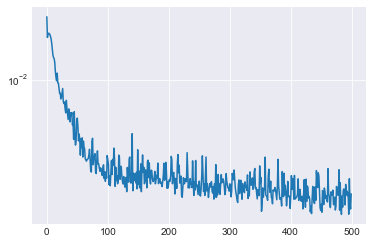

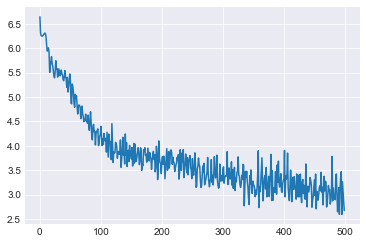

In [37]:
sparse_me_model_3 = maxent_fit(sparse_trajs_3, restraints_3)

Plotting 10 patches in a 3 x 4 grid


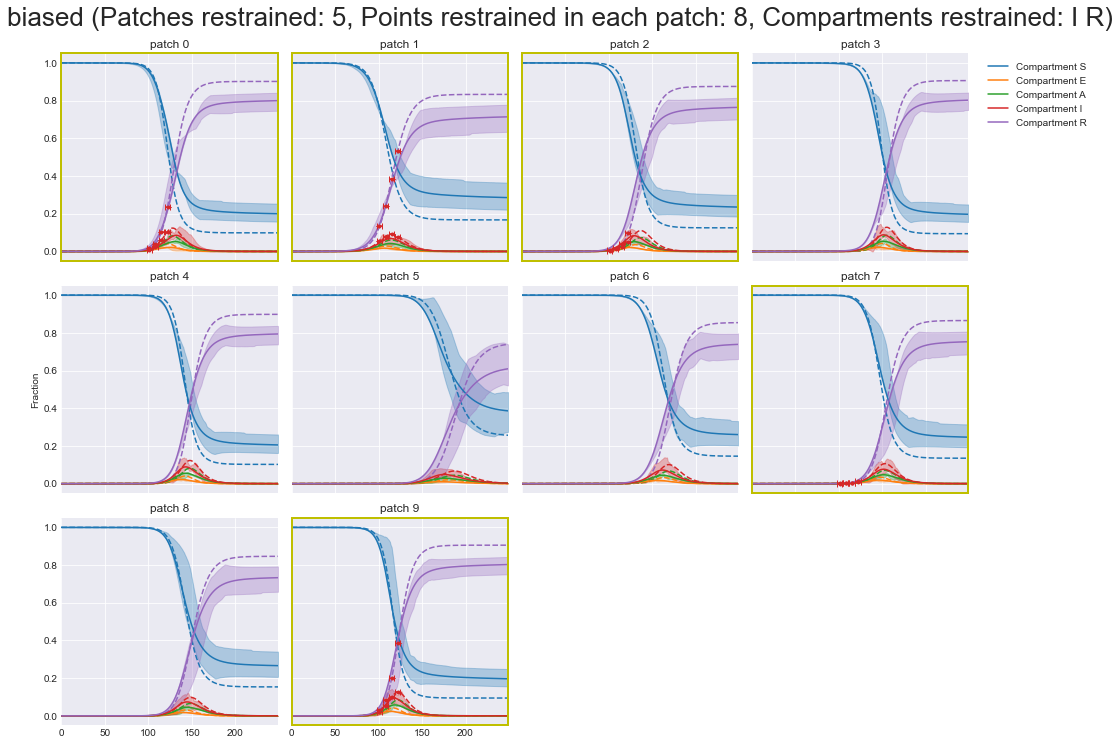

In [38]:
me_w_3 = sparse_me_model_3.traj_weights
weights_dict_3 = {'unbiased':None, 'biased':me_w_3}
compare_patches(sparse_ref_traj_3, sparse_trajs_3, weights_dict_3,'biased', restrained_patches_3, plot_fxns_list_3,
                patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)

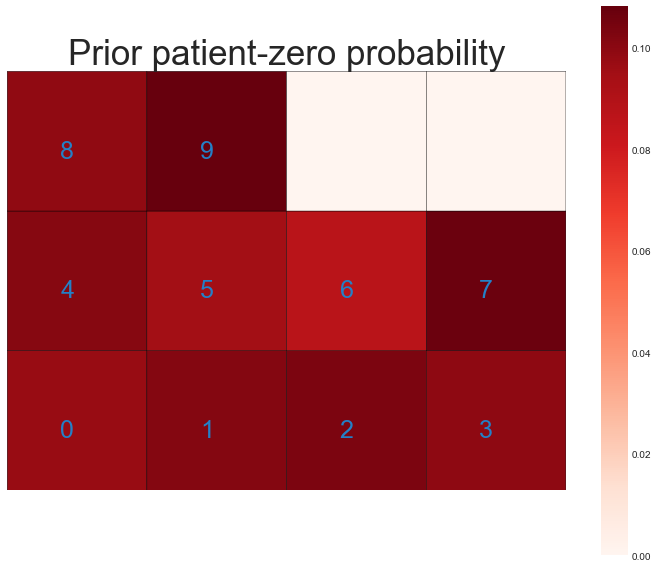

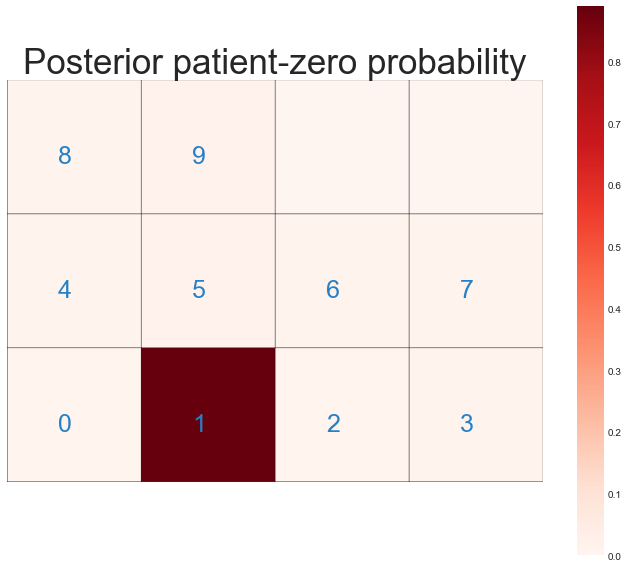

In [39]:
prior_exposed_patch_3 = maxentep.exposed_finder(sparse_trajs_3)
maxentep.p0_map(prior_exposed_patch_3, M, weights = None, title = 'Prior patient-zero probability', fontsize=25, figsize=(10,8))
maxentep.p0_map(prior_exposed_patch_3, M, weights = me_w_3, 
                title = 'Posterior patient-zero probability', fontsize=25,figsize=(10,8))

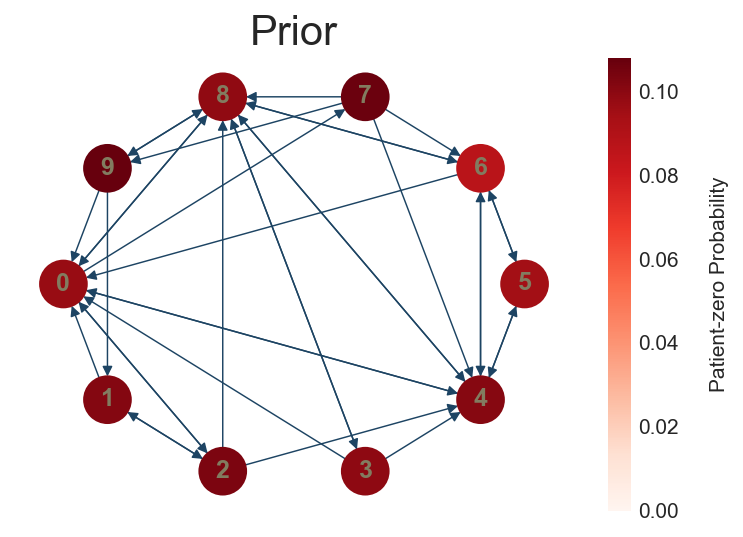

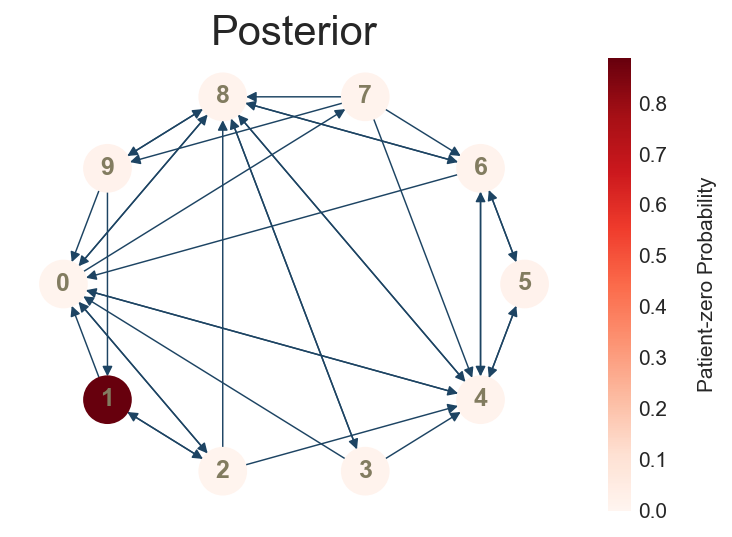

In [40]:
exposed_prob_3 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_3, M)
weighted_exposed_prob_3 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_3, M, weights=me_w_3)
maxentep.draw_graph(graph_3, weights=exposed_prob_3, title='Prior', heatmap=True)
fig, ax = plt.subplots()
maxentep.draw_graph(graph_3, weights=weighted_exposed_prob_3, title='Posterior', heatmap=True)

In [41]:
traj_loss_3 = maxentep.traj_loss(sparse_ref_traj_3, sparse_trajs_2, me_w_3)
p0_loss_3 = maxentep.p0_loss(sparse_trajs_3,me_w_3,true_p0_node)
print(f'P0 cross-entropy : {p0_loss_3:.3f}, Traj KL : {traj_loss_3:.3f}')
print('Top 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob_3, patches), reverse=True)[:5])

P0 cross-entropy : 0.117, Traj KL : 0.279
Top 5 posterior probabilities for P0: 
 [(0.8896549147264077, 'patch 1'), (0.015254406283761617, 'patch 5'), (0.013973338239790216, 'patch 9'), (0.01344916648285459, 'patch 3'), (0.013019396399260173, 'patch 6')]


# Case 4

3.3

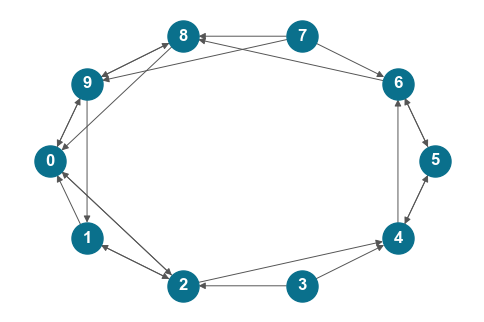

In [42]:
graph_4, edge_list_4, node_list_4 = maxentep.gen_graph(10)
graph_4.remove_edges_from([(1, i) for i in range(3,9)])
graph_4.remove_edges_from([(i, 1) for i in range(0,9) if i != 2 and i!=1])
graph_4.remove_edges_from([(i, 2) for i in range(4,9)])
graph_4.remove_edges_from([(i, 6) for i in range(0,4)])
graph_4.remove_edges_from([(i, 7) for i in range(1,10) if i!=7])
graph_4.remove_edges_from([(7, i) for i in range(0,5) if i!=4])
graph_4.remove_edges_from([(5, i) for i in range(0,9) if i!=6 and i!=4 and i!=5] )
graph_4.remove_edges_from([(i, 5) for i in range(0,9)  if i!=6 and i!=4 and i!=5])
graph_4.remove_edges_from([(i, 3) for i in range(0,7) if i!=3])
graph_4.remove_edges_from([(9,i) for i in range(2,8)])
graph_4.remove_edges_from([(i,9) for i in range(1,7)])
graph_4.remove_edges_from([(0, i) for i in range(3,9)])
graph_4.remove_edges_from([(i, 0) for i in range(3,8)])
graph_4.remove_edges_from([(i, 8) for i in range(2,6)])
graph_4.remove_edges_from([(8, i) for i in range(1,8) if i!=7 and i!=8])
graph_4.remove_edges_from([(i, 4) for i in range(6,9)])
maxentep.draw_graph(graph_4, dpi=100)
dof_4 = maxentep.graph_dof(graph_4.edges(), node_list_4)
dof_4


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Plotting 10 patches in a 3 x 4 grid


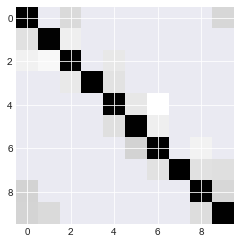

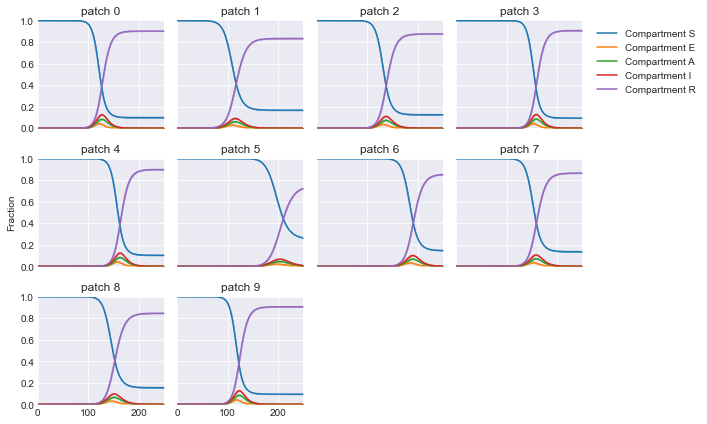

In [43]:
sparse_mobility_matrix_4 = sparse_graph_mobility(graph_4, mobility_matrix)
plt.imshow(np.log(sparse_mobility_matrix_4))
sparse_ref_traj_4 = gen_ref_traj(M=10, timesteps=250, population=population,
                          area=area, mobility_matrix=sparse_mobility_matrix_4)
maxentep.patch_quantile(sparse_ref_traj_4, patch_names = patches, figsize=(10, 6), alpha=0.5, names=['S','E','A','I','R'])


Restraints are set in this time range: [100, 130]
108 0.07932925 0.0784722513534861
122 0.078763604 0.07955272684903965
101 0.054222208 0.05286006959485961
115 0.08986384 0.09109146967395546
115 0.38459417 0.38592195493526155
101 0.13276814 0.1326668577569085
108 0.24189411 0.2410909696499127
122 0.5289672 0.5285028640183118
101 7.917837e-05 0.0
115 0.0007420485 0.00023175575115888438
122 0.0022340838 0.002418009327513227
108 0.00024347428 0.0
122 0.0031064537 0.0006293562752079378
101 0.00010706105 0.00019336542386052147
108 0.00033195416 0.0016138733443700989
115 0.0010204159 0.0005500244248890106
101 6.0882405e-07 0.0
115 5.736271e-06 0.0
122 1.7318545e-05 0.0
108 1.8792001e-06 0.0
108 2.548648e-06 0.0
115 7.867091e-06 0.002510512539232508
122 2.4010425e-05 0.0002868060525257733
101 8.155206e-07 0.0
108 5.5390883e-06 0.0
115 1.7005586e-05 0.0
122 5.090108e-05 0.0018058872325357445
101 1.7702583e-06 0.0
108 7.409675e-06 0.00011004483333943438
115 2.3147892e-05 0.0
122 7.086686e-05 0.

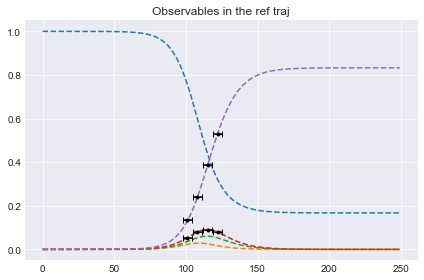

In [51]:
restraints_4, plot_fxns_list_4, restrained_patches_4 = gen_restraints(sparse_ref_traj_4)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:16<00:00,  2.12s/it]


Plotting 10 patches in a 3 x 4 grid


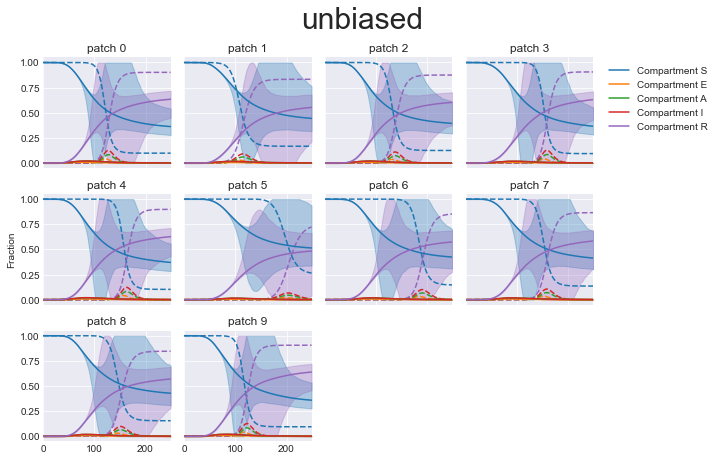

In [52]:
sparse_trajs_4 = gen_samples(sparse_mobility_matrix_4, timesteps =250, area = area, populations = population)
compare_to_ref(sparse_ref_traj_4, sparse_trajs_4, weights=None, method='unbiased', patch_names = patches,
               figsize=(10, 6), alpha=0.3, names=full_compartments)

Epoch 1/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0184 - weight-entropy: 6.7144
Epoch 2/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0114 - weight-entropy: 6.4213
Epoch 3/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0118 - weight-entropy: 6.3511
Epoch 4/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0119 - weight-entropy: 6.3216
Epoch 5/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0119 - weight-entropy: 6.3094
Epoch 6/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0119 - weight-entropy: 6.3045
Epoch 7/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0119 - weight-entropy: 6.3039
Epoch 8/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0118 - weight-entropy: 6.3072
Epoch 9/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0117 - weight-entropy: 6.3131
Epoch 10/500
4/4 [==============================] - 0s 1ms/step - loss: 0

4/4 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 4.7957
Epoch 80/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 4.7547
Epoch 81/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.7083
Epoch 82/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 4.8276
Epoch 83/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 4.8531
Epoch 84/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0016 - weight-entropy: 4.7940
Epoch 85/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0010 - weight-entropy: 4.6577
Epoch 86/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 4.6438
Epoch 87/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0018 - weight-entropy: 4.8937
Epoch 88/500
4/4 [==============================] - 0s 1ms/step - loss: 0.001

4/4 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 4.4507
Epoch 157/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0014 - weight-entropy: 4.5061
Epoch 158/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.3852
Epoch 159/500
4/4 [==============================] - 0s 2ms/step - loss: 9.9774e-04 - weight-entropy: 4.4608
Epoch 160/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 4.6039
Epoch 161/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 4.4604
Epoch 162/500
4/4 [==============================] - 0s 1ms/step - loss: 9.5858e-04 - weight-entropy: 4.5241
Epoch 163/500
4/4 [==============================] - 0s 2ms/step - loss: 8.9033e-04 - weight-entropy: 4.4842
Epoch 164/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0010 - weight-entropy: 4.4730
Epoch 165/500
4/4 [==============================] - 0s 1

4/4 [==============================] - 0s 1ms/step - loss: 8.7680e-04 - weight-entropy: 4.2379
Epoch 233/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 4.2881
Epoch 234/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.1849
Epoch 235/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.1783
Epoch 236/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 4.3385
Epoch 237/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 4.3774
Epoch 238/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0010 - weight-entropy: 4.0043
Epoch 239/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0010 - weight-entropy: 4.2595
Epoch 240/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 4.1053
Epoch 241/500
4/4 [==============================] - 0s 2ms/step 

4/4 [==============================] - 0s 2ms/step - loss: 6.8942e-04 - weight-entropy: 3.8638
Epoch 308/500
4/4 [==============================] - 0s 2ms/step - loss: 9.0001e-04 - weight-entropy: 3.8431
Epoch 309/500
4/4 [==============================] - 0s 2ms/step - loss: 9.9371e-04 - weight-entropy: 3.9086
Epoch 310/500
4/4 [==============================] - 0s 2ms/step - loss: 9.5269e-04 - weight-entropy: 4.0684
Epoch 311/500
4/4 [==============================] - 0s 1ms/step - loss: 8.4592e-04 - weight-entropy: 4.0234
Epoch 312/500
4/4 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.0417
Epoch 313/500
4/4 [==============================] - 0s 1ms/step - loss: 8.7506e-04 - weight-entropy: 3.9015
Epoch 314/500
4/4 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 3.8540
Epoch 315/500
4/4 [==============================] - 0s 2ms/step - loss: 7.2589e-04 - weight-entropy: 3.7910
Epoch 316/500
4/4 [======================

4/4 [==============================] - 0s 1ms/step - loss: 5.8361e-04 - weight-entropy: 3.8071
Epoch 382/500
4/4 [==============================] - 0s 2ms/step - loss: 8.2931e-04 - weight-entropy: 3.8182
Epoch 383/500
4/4 [==============================] - 0s 2ms/step - loss: 7.3395e-04 - weight-entropy: 3.8671
Epoch 384/500
4/4 [==============================] - 0s 2ms/step - loss: 6.1289e-04 - weight-entropy: 3.6937
Epoch 385/500
4/4 [==============================] - 0s 2ms/step - loss: 9.2987e-04 - weight-entropy: 3.8528
Epoch 386/500
4/4 [==============================] - 0s 2ms/step - loss: 7.2564e-04 - weight-entropy: 3.7337
Epoch 387/500
4/4 [==============================] - 0s 1ms/step - loss: 7.6753e-04 - weight-entropy: 3.7359
Epoch 388/500
4/4 [==============================] - 0s 2ms/step - loss: 6.0998e-04 - weight-entropy: 3.6470
Epoch 389/500
4/4 [==============================] - 0s 1ms/step - loss: 6.0422e-04 - weight-entropy: 3.4735
Epoch 390/500
4/4 [==============

4/4 [==============================] - 0s 1ms/step - loss: 6.7737e-04 - weight-entropy: 3.3565
Epoch 457/500
4/4 [==============================] - 0s 2ms/step - loss: 6.2516e-04 - weight-entropy: 3.4057
Epoch 458/500
4/4 [==============================] - 0s 2ms/step - loss: 6.1225e-04 - weight-entropy: 3.6049
Epoch 459/500
4/4 [==============================] - 0s 2ms/step - loss: 6.5074e-04 - weight-entropy: 3.4770
Epoch 460/500
4/4 [==============================] - 0s 2ms/step - loss: 6.1433e-04 - weight-entropy: 3.3005
Epoch 461/500
4/4 [==============================] - 0s 1ms/step - loss: 5.5004e-04 - weight-entropy: 3.4047
Epoch 462/500
4/4 [==============================] - 0s 1ms/step - loss: 6.2692e-04 - weight-entropy: 3.3994
Epoch 463/500
4/4 [==============================] - 0s 2ms/step - loss: 4.9949e-04 - weight-entropy: 3.3517
Epoch 464/500
4/4 [==============================] - 0s 1ms/step - loss: 4.4836e-04 - weight-entropy: 3.3429
Epoch 465/500
4/4 [==============

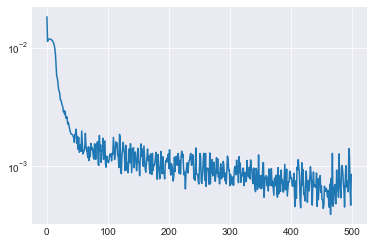

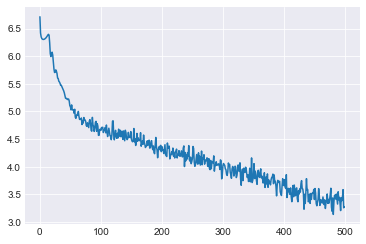

In [53]:
sparse_me_model_4 = maxent_fit(sparse_trajs_4, restraints_4)

Plotting 10 patches in a 3 x 4 grid


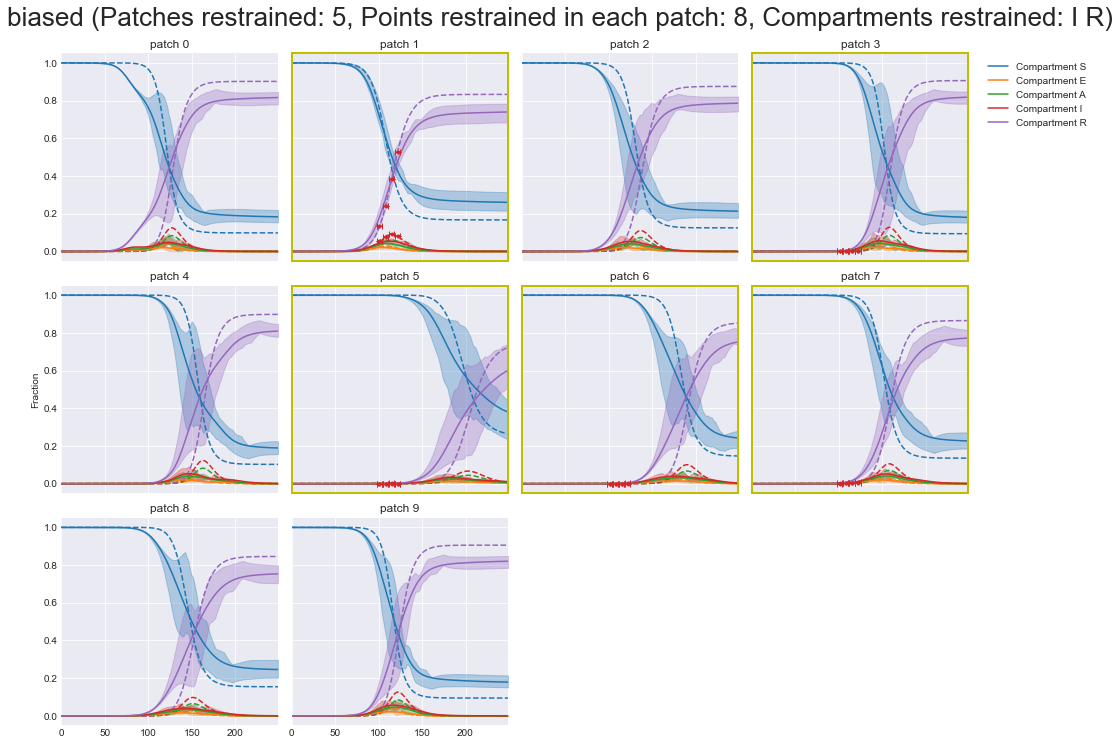

In [54]:
me_w_4 = sparse_me_model_4.traj_weights
weights_dict_4 = {'unbiased':None, 'biased':me_w_4}
compare_patches(sparse_ref_traj_4, sparse_trajs_4, weights_dict_4,'biased', restrained_patches_4, plot_fxns_list_4,
                patch_names = patches, figsize=(15, 10), alpha=0.3, names=full_compartments)

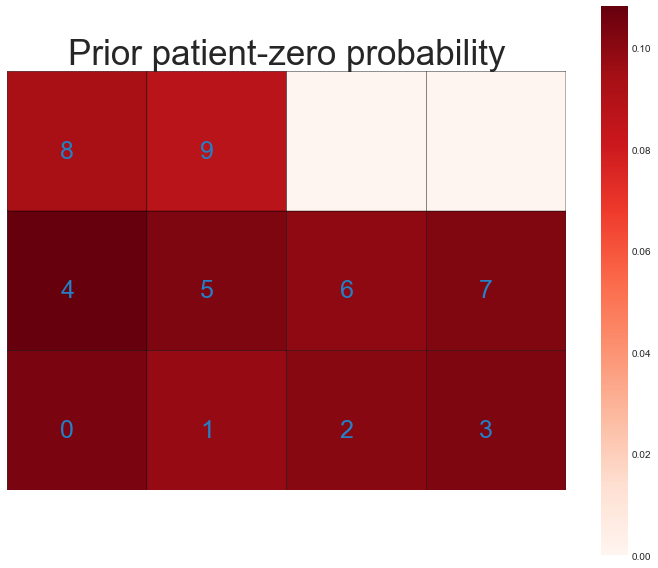

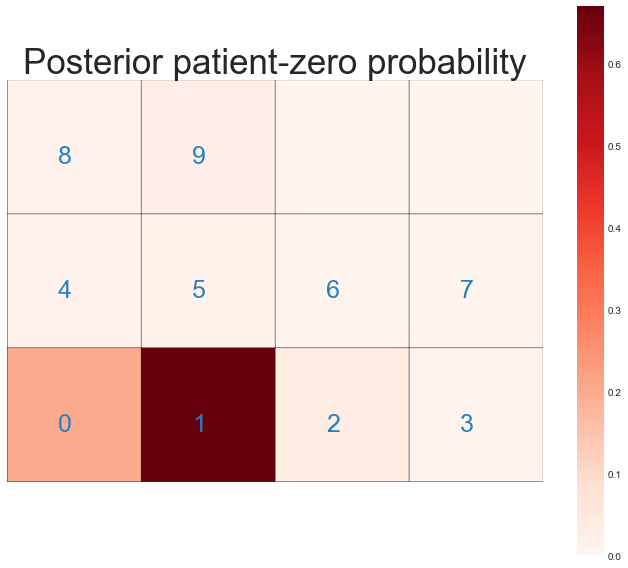

In [55]:
prior_exposed_patch_4 = maxentep.exposed_finder(sparse_trajs_4)
maxentep.p0_map(prior_exposed_patch_4, M, weights = None, title = 'Prior patient-zero probability', fontsize=25, figsize=(10,8))
maxentep.p0_map(prior_exposed_patch_4, M, weights = me_w_4, 
                title = 'Posterior patient-zero probability', fontsize=25,figsize=(10,8))


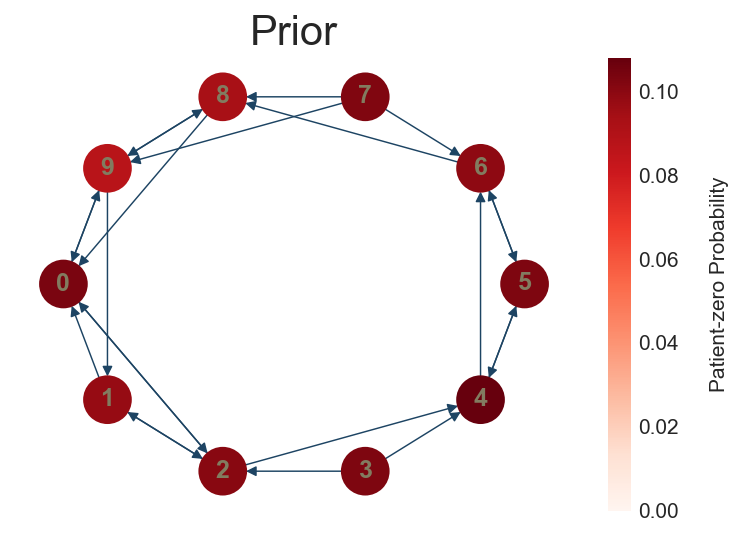

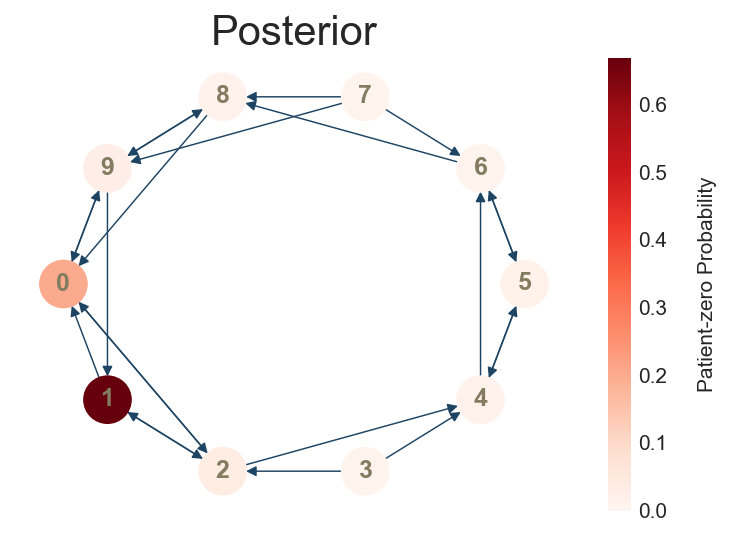

In [56]:
exposed_prob_4 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_4, M)
weighted_exposed_prob_4 = maxentep.weighted_exposed_prob_finder(
                            prior_exposed_patch_4, M, weights=me_w_4)
maxentep.draw_graph(graph_4, weights=exposed_prob_4, title='Prior', heatmap=True)
fig, ax = plt.subplots()
maxentep.draw_graph(graph_4, weights=weighted_exposed_prob_4, title='Posterior', heatmap=True)

In [57]:
traj_loss_4 = maxentep.traj_loss(sparse_ref_traj_4, sparse_trajs_4, me_w_4)
p0_loss_4 = maxentep.p0_loss(sparse_trajs_4,me_w_4, true_p0_node)
print(f'P0 cross-entropy : {p0_loss_4:.3f}, Traj KL : {traj_loss_4:.3f}')
print('Top 5 posterior probabilities for P0: \n', sorted(zip(weighted_exposed_prob_4, patches), reverse=True)[:5])

P0 cross-entropy : 0.401, Traj KL : 0.033
Top 5 posterior probabilities for P0: 
 [(0.6695087205201204, 'patch 1'), (0.20318282303020685, 'patch 0'), (0.03662437569212489, 'patch 2'), (0.02615787511956943, 'patch 9'), (0.014131993809888803, 'patch 5')]


Text(0, 0.5, 'Certainty in the Origin of Patinet-zero ')

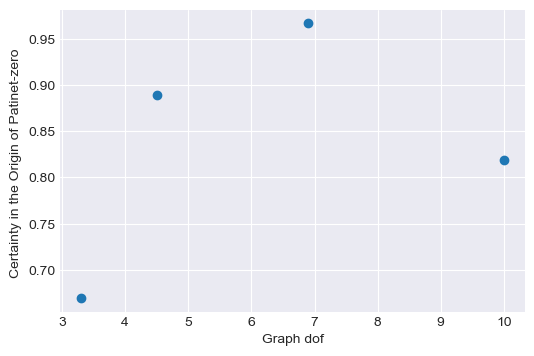

In [58]:
p0_probs = [max(weighted_exposed_prob_1),max(weighted_exposed_prob_2),max(weighted_exposed_prob_3),max(weighted_exposed_prob_4)]
dofs = [dof_1, dof_2, dof_3, dof_4]
fig, ax = plt.subplots(dpi=100)
plt.scatter(dofs,p0_probs)
ax.set_xlabel('Graph dof')
ax.set_ylabel('Certainty in the Origin of Patinet-zero ')